In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/soc-data-set/CUB_200_2011/attributes.txt
/kaggle/input/soc-data-set/CUB_200_2011/CUB_200_2011/images.txt
/kaggle/input/soc-data-set/CUB_200_2011/CUB_200_2011/train_test_split.txt
/kaggle/input/soc-data-set/CUB_200_2011/CUB_200_2011/image_class_labels.txt
/kaggle/input/soc-data-set/CUB_200_2011/CUB_200_2011/README
/kaggle/input/soc-data-set/CUB_200_2011/CUB_200_2011/classes.txt
/kaggle/input/soc-data-set/CUB_200_2011/CUB_200_2011/bounding_boxes.txt
/kaggle/input/soc-data-set/CUB_200_2011/CUB_200_2011/parts/part_click_locs.txt
/kaggle/input/soc-data-set/CUB_200_2011/CUB_200_2011/parts/part_locs.txt
/kaggle/input/soc-data-set/CUB_200_2011/CUB_200_2011/parts/parts.txt
/kaggle/input/soc-data-set/CUB_200_2011/CUB_200_2011/images/037.Acadian_Flycatcher/Acadian_Flycatcher_0041_795605.jpg
/kaggle/input/soc-data-set/CUB_200_2011/CUB_200_2011/images/037.Acadian_Flycatcher/Acadian_Flycatcher_0066_29190.jpg
/kaggle/input/soc-data-set/CUB_200_2011/CUB_200_2011/images/037.Acadian_Flycat

In [4]:
!tar -xvf path_to_zip file

tar: path_to_zip: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [9]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths to the data directories
base_dir = '/kaggle/input/soc-data-set/CUB_200_2011/CUB_200_2011'
train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test'

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize to match the input size of the pre-trained model
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 5994 images belonging to 200 classes.
Found 5794 images belonging to 200 classes.


In [14]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Load pre-trained MobileNetV2 model + higher level layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Setup callbacks
checkpoint = ModelCheckpoint('model_checkpoint.keras', save_best_only=True, monitor='val_accuracy', mode='max')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 32,
    epochs=10,
    callbacks=[checkpoint]
)


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/187 ━━━━━━━━━━━━━━━━━━━━ 47:51 15s/step - accuracy: 0.0000e+00 - loss: 17.0074

I0000 00:00:1722883764.735483    8287 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722883764.765497    8287 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.1092 - loss: 10.5338

W0000 00:00:1722883839.337262    8289 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


187/187 ━━━━━━━━━━━━━━━━━━━━ 107s 490ms/step - accuracy: 0.1096 - loss: 10.5165 - val_accuracy: 0.3033 - val_loss: 4.1142
Epoch 2/10
  1/187 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.2188 - loss: 4.5676

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.2188 - loss: 4.5676 - val_accuracy: 0.0000e+00 - val_loss: 4.4678
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 85s 443ms/step - accuracy: 0.3680 - loss: 3.5961 - val_accuracy: 0.3512 - val_loss: 3.3786
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step - accuracy: 0.3438 - loss: 3.4451 - val_accuracy: 0.0000e+00 - val_loss: 3.9442
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 85s 439ms/step - accuracy: 0.4312 - loss: 3.0176 - val_accuracy: 0.3676 - val_loss: 3.2297
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1562 - loss: 3.6718 - val_accuracy: 0.5000 - val_loss: 4.8056
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 84s 438ms/step - accuracy: 0.4864 - loss: 2.7544 - val_accuracy: 0.3890 - val_loss: 3.0687
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 141us/step - accuracy: 0.3438 - loss: 2.9903 - val_accuracy: 0.5000 - val_loss: 3.6868
Epoch 9/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 85s 441ms/step - accuracy: 0.4943 - loss: 2.6652 - va

In [18]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')
print('Test accuracy:', accuracy*100.0,'%')

# Save the model
model.save('final_model.h5')


182/182 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.4259 - loss: 2.9499
Test Loss: 2.9491477012634277
Test Accuracy: 0.41957196593284607
Test accuracy: 41.95719659328461 %


Epoch 1/4
  1/187 ━━━━━━━━━━━━━━━━━━━━ 2:49:07 55s/step - accuracy: 0.2500 - loss: 3.8013

W0000 00:00:1722884918.611857    8287 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.3875 - loss: 3.2264

W0000 00:00:1722885012.356309    8287 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


187/187 ━━━━━━━━━━━━━━━━━━━━ 164s 589ms/step - accuracy: 0.3879 - loss: 3.2248 - val_accuracy: 0.4525 - val_loss: 2.7877
Epoch 2/4
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4375 - loss: 2.7919 - val_accuracy: 0.5000 - val_loss: 2.2919
Epoch 3/4
187/187 ━━━━━━━━━━━━━━━━━━━━ 87s 454ms/step - accuracy: 0.5933 - loss: 2.4226 - val_accuracy: 0.4763 - val_loss: 2.6863
Epoch 4/4
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 192us/step - accuracy: 0.6875 - loss: 2.2480 - val_accuracy: 0.5000 - val_loss: 2.7405


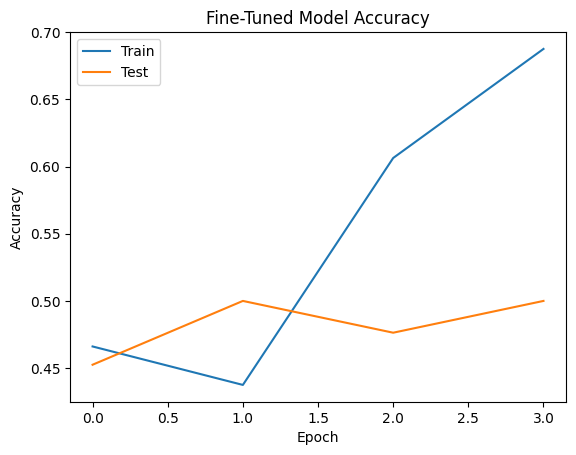

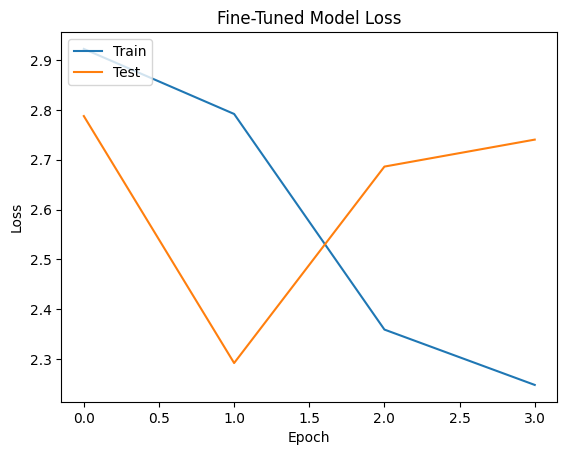

In [19]:
# Unfreeze all layers in the base model
base_model.trainable = True

# To avoid training all layers at once, you might want to use a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training the model with all layers unfrozen
history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 32,
    epochs=4,  # Train for 3-4 epochs
    callbacks=[checkpoint]
)

# Save the model after fine-tuning
model.save('fine_tuned_model.keras')


Epoch 1/10
  1/187 ━━━━━━━━━━━━━━━━━━━━ 36:58 12s/step - accuracy: 1.0000 - loss: 0.7200

W0000 00:00:1722887149.479144    8289 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.8803 - loss: 0.9602

W0000 00:00:1722887220.567709    8290 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


187/187 ━━━━━━━━━━━━━━━━━━━━ 99s 466ms/step - accuracy: 0.8802 - loss: 0.9604 - val_accuracy: 0.5428 - val_loss: 2.0786
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7188 - loss: 1.4479 - val_accuracy: 0.5000 - val_loss: 4.1528
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 85s 443ms/step - accuracy: 0.8885 - loss: 0.9328 - val_accuracy: 0.5458 - val_loss: 2.0737
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 126us/step - accuracy: 0.9375 - loss: 0.8091 - val_accuracy: 1.0000 - val_loss: 0.4368
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 85s 442ms/step - accuracy: 0.9184 - loss: 0.8462 - val_accuracy: 0.5542 - val_loss: 2.0209
Epoch 10/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 150us/step - accuracy: 0.8438 - loss: 0.8891 - val_accuracy: 0.0000e+00 - val_loss: 2.7869


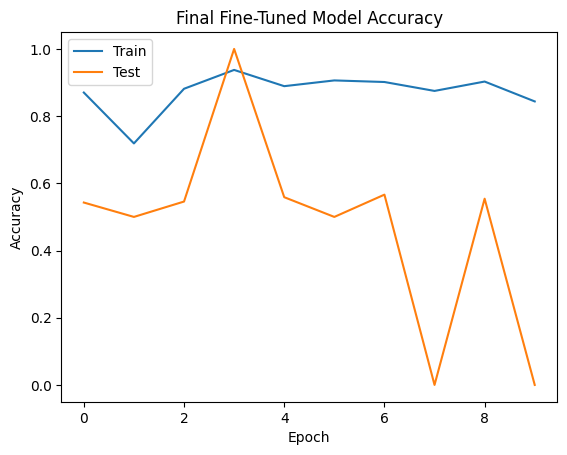

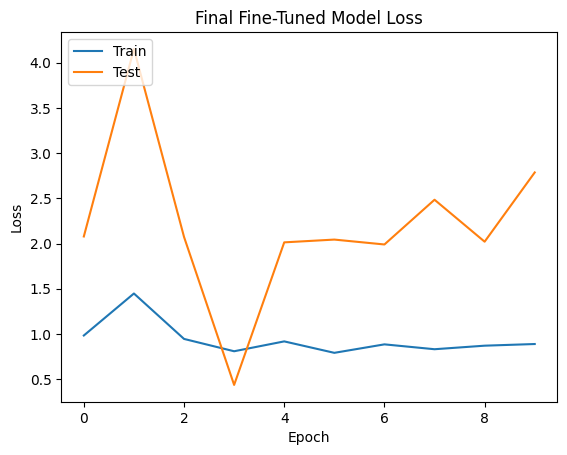

182/182 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.5509 - loss: 2.0421
Final Tuned Test Loss: 2.024414300918579
Final Tuned Test Accuracy (Fraction): 0.5538488030433655
Final Tuned Test Accuracy (Percentage): 55.38%


In [25]:
# Re-freeze all layers
for layer in base_model.layers[:-10]:  # Freezing all 10 layers
    layer.trainable = False

# Ensure the final few layers are trainable
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile the model with a potentially higher learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with the last layers unfrozen
history_final_tune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 32,
    epochs=10,  # Train for 10 more epochs
    callbacks=[checkpoint]
)

# Save the final model
model.save('final_tuned_model.keras')

# Visualization
plt.plot(history_final_tune.history['accuracy'])
plt.plot(history_final_tune.history['val_accuracy'])
plt.title('Final Fine-Tuned Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_final_tune.history['loss'])
plt.plot(history_final_tune.history['val_loss'])
plt.title('Final Fine-Tuned Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

loss, accuracy = model.evaluate(test_generator)
print(f'Final Tuned Test Loss: {loss}')
print(f'Final Tuned Test Accuracy (Fraction): {accuracy}')

# Calculate accuracy percentage
accuracy_percentage_final_tune = accuracy * 100
print(f'Final Tuned Test Accuracy (Percentage): {accuracy_percentage_final_tune:.2f}%')